In [12]:
import networkx as nx
import pandas as pd
import json

from matplotlib import pyplot as plt
from collections.abc import Mapping
from typing import Any, Literal
from itertools import product
from pathlib import Path

In [13]:
def load_records(result_file_name: str) -> list[Mapping[str, Any]]:
    records: list[Mapping[str, Any]] = []
    with open(Path("./results") / result_file_name, 'r') as file:
        dpth: int = 0
        buff: list[str] = []
        for raw in file:
            line = raw.strip()
            if not line:
                continue
            dpth += line.count('{')
            dpth -= line.count('}')
            buff.append(raw)
            if dpth == 0 and buff:
                chunk = ''.join(buff)
                obj = json.loads(chunk)
                records.append(obj)
                buff = []
    return records

In [14]:
def best_record(records: list[Mapping[str, Any]]) -> Mapping[str, Any]:
    best: Mapping[str, Any] = {}
    for record in records:
        for uid, details in record.items():
            if not best or details['score'] < best['score']:
                best = {'id': uid, **details}
    return best

In [15]:
def load_config(result_file_name: str) -> Mapping[str, Any]:
    stem = Path(result_file_name).stem            
    config_name = stem.removeprefix("result_")      
    
    config_path = Path("configurations") / f"{config_name}.json"
    
    # 3) Open & load the JSON
    with config_path.open("r", encoding="utf-8") as f:
        config = json.load(f)
    return config

In [16]:
def load_experiment(experiment_name: str) -> Mapping[str, Any]:
    result_file_name = f"result_{experiment_name}.jsonl"
    records = load_records(result_file_name)
    best = best_record(records)
    config = load_config(result_file_name)
    return {
        "name": experiment_name,
        "result": best,
        "config": config
    }

In [17]:
def load_all_experiments() -> list[Mapping[str, Any]]:
    experiments: list[Mapping[str, Any]] = []
    for result_file in Path("./results").glob("result_*.jsonl"):
        experiment_name = result_file.stem.removeprefix("result_")
        experiment = load_experiment(experiment_name)
        experiments.append(experiment)
    return experiments

In [18]:
def only_experiments_with(algorithm: Literal["ST", "TF", "GDFS"], weights: tuple[float, float, float, float]) -> list[Mapping[str, Any]]:
    experiments = load_all_experiments()
    filtered: list[Mapping[str, Any]] = []
    for experiment in experiments:
        config = experiment["config"]
        optimizer = config["optimizer"]
        if config["reconstruction_algo"] == algorithm and optimizer["weights"] == list(weights):
            filtered.append(experiment)
    return filtered

In [19]:
def extract_label(experiment: Mapping[str, Any]) -> str:
    solver = experiment["config"]["solverName"]
    algorithm = experiment["config"]["reconstruction_algo"]
    hyperparams = experiment["config"]["optimizer"]
    hyperparams = {k: v for k, v in hyperparams.items() if k not in ["max_iterations", "objective", "nested"]}
    proto_label = {
        "solver": solver,
        "algorithm": algorithm,
        "hyperparams": hyperparams
    }
    return json.dumps(proto_label, sort_keys=True)

In [20]:
def dominance_network(experiments: list[Mapping[str, Any]], by: str = "score", mode: str = "min") -> nx.Graph:
    network = nx.DiGraph()
    for exp_a, exp_b in product(experiments, repeat=2):
        if exp_a == exp_b:
            continue
        score_a = exp_a["result"].get(by, float('inf'))
        score_b = exp_b["result"].get(by, float('inf'))
        if (score_a < score_b and mode == "min") or (score_b < score_a and mode == "max"):
            network.add_node(extract_label(exp_a), reference=exp_a)
            network.add_node(extract_label(exp_b), reference=exp_b)
            network.add_edge(extract_label(exp_a), extract_label(exp_b))
    return network

In [21]:
def rank_nodes_by_dominance(network: nx.DiGraph) -> list[tuple[str, int, int, float]]:
    """
    Rank nodes in the dominance network by the number of configurations they dominate.
    
    Args:
        network: A NetworkX DiGraph representing dominance relationships
        
    Returns:
        A list of (node_label, outgoing_edges_count, dominance_ratio) sorted by count in descending order
    """
    # Get the out-degree (number of outgoing edges) for each node
    out_degrees = dict(network.out_degree())
    
    # Get total number of nodes (excluding self)
    total_possible_dominance = len(network.nodes()) - 1
    
    # Calculate dominance ratio and create the ranking list
    ranked_nodes = []
    for node, dominates in out_degrees.items():
        # Dominance ratio: what percentage of other configs this one dominates
        dominated_by = network.in_degree(node)
        dominance_ratio = dominates / max(1, total_possible_dominance)
        ranked_nodes.append((node, dominates, dominated_by, dominance_ratio))
    
    # Sort by count in descending order
    ranked_nodes.sort(key=lambda x: x[1] - x[1], reverse=True)
    
    return ranked_nodes

In [22]:
def display_dominance_ranking(ranked_nodes: list[tuple[str, int, int, float]], network: nx.DiGraph, add: bool = True) -> None:
    """
    Display the ranked nodes with their dominance metrics in a readable format.
    
    Args:
        ranked_nodes: List of (node_label, outgoing_edges_count, dominance_ratio)
        network: The dominance network to extract in-degree information
    """
    
    # Get the in-degree (number of incoming edges) for each node
    
    # Create a table for display
    print(f"{'Rank':<5} {'Dominates':<10} {'Dominated by':<12} {'Ratio':<8} {'Configuration':<45}")
    print("-" * 90)
    
    for rank, (node, dominates, dominated_by, ratio) in enumerate(ranked_nodes, 1):
        # Get number of configurations that dominate this one
        if add:
            network.nodes[node]["reference"]["result"]["rank"] = network.nodes[node]["reference"]["result"].get("rank", 0.) + rank
        data = json.loads(node)
        solver = data['solver']
        algo = data['algorithm']
        hparams = data['hyperparams']
        config_str = f"{solver} on {algo} with {', '.join(f'{k}={v}' for k, v in hparams.items())}"
            
        print(f"{rank:<5} {dominates:<10} {dominated_by:<12} {ratio:.2f}     {config_str}")

In [23]:
all_algorithms: list[str] = ["ST", "TF"]
all_weights: list[tuple[float, float, float, float]] = [
    (0.1, 0.3, 0.5, -10.0),
    (0.01, 0.5, 0.5, -7.0),
    (0.4, 0.2, 0.5, -7.0),
    (0.4, 0.2, 0.3, -5.0),
]
all_experiments = []
for algorithm, weights in product(all_algorithms, all_weights):
    print(f"Algorithm: {algorithm}, Weights: {weights}")
    filtered_experiments = only_experiments_with(algorithm, weights)
    all_experiments.extend(filtered_experiments)
    if not filtered_experiments:
        print("No experiments found for this configuration.")
        continue
    score_network = dominance_network(filtered_experiments)
    display_dominance_ranking(rank_nodes_by_dominance(score_network), score_network)
    print("\n" + "="*80 + "\n")

Algorithm: ST, Weights: (0.1, 0.3, 0.5, -10.0)
Rank  Dominates  Dominated by Ratio    Configuration                                
------------------------------------------------------------------------------------------
1     9          6            0.60     Bayesian on ST with learning_rate=0.001, target_score=0.01, weights=[0.1, 0.3, 0.5, -10.0]
2     8          7            0.53     Bayesian on ST with learning_rate=0.001, target_score=0.3, weights=[0.1, 0.3, 0.5, -10.0]
3     7          8            0.47     Bayesian on ST with learning_rate=0.01, target_score=0.01, weights=[0.1, 0.3, 0.5, -10.0]
4     6          9            0.40     Bayesian on ST with learning_rate=0.01, target_score=0.1, weights=[0.1, 0.3, 0.5, -10.0]
5     5          10           0.33     Bayesian on ST with learning_rate=0.1, target_score=0.1, weights=[0.1, 0.3, 0.5, -10.0]
6     4          11           0.27     ParticleSwarm on ST with cognitive=1.5, inertia=0.5, social=1.5, swarm_size=3, weights=[0.1, 0.

In [24]:
print(json.dumps(all_experiments[0], indent=2))

{
  "name": "Bayesian_ST_1_50e1048d-3909-40da-bf28-3cf598be9e5c",
  "result": {
    "id": "a7c9c201-1f5b-4b59-85e6-7f7361da5f09",
    "params": {
      "scatter": 0.8173743239779684,
      "min_strong_track_length": 2,
      "allowed_missed_modules": 5
    },
    "score": -661751.1680968892,
    "total_ghosts": 37063,
    "overall_ghost_rate": 56.005016772945694,
    "event_avg_ghost_rate": 49.5906531428739,
    "clone_percentage": 2.596478063189732,
    "total_tracks": 66178,
    "time": 0.7583944797515869,
    "rank": 1.0
  },
  "config": {
    "solverName": "Bayesian",
    "num_events": 100,
    "intra_node": true,
    "max_runs": 21,
    "optimizer": {
      "max_iterations": 21,
      "objective": "min",
      "nested": true,
      "weights": [
        0.1,
        0.3,
        0.5,
        -10.0
      ],
      "learning_rate": 0.001,
      "target_score": 0.01
    },
    "reconstruction_algo": "ST"
  }
}


           solver                                        hyperparams  \
0        Bayesian     {'learning_rate': 0.001, 'target_score': 0.01}   
3        Bayesian      {'learning_rate': 0.01, 'target_score': 0.01}   
11  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
1        Bayesian      {'learning_rate': 0.001, 'target_score': 0.1}   
4        Bayesian       {'learning_rate': 0.01, 'target_score': 0.1}   
12  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
5        Bayesian       {'learning_rate': 0.01, 'target_score': 0.3}   
6        Bayesian       {'learning_rate': 0.1, 'target_score': 0.01}   
13  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
2        Bayesian      {'learning_rate': 0.001, 'target_score': 0.3}   
7        Bayesian        {'learning_rate': 0.1, 'target_score': 0.1}   
15       PolyHoot                                                 {}   
14  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 

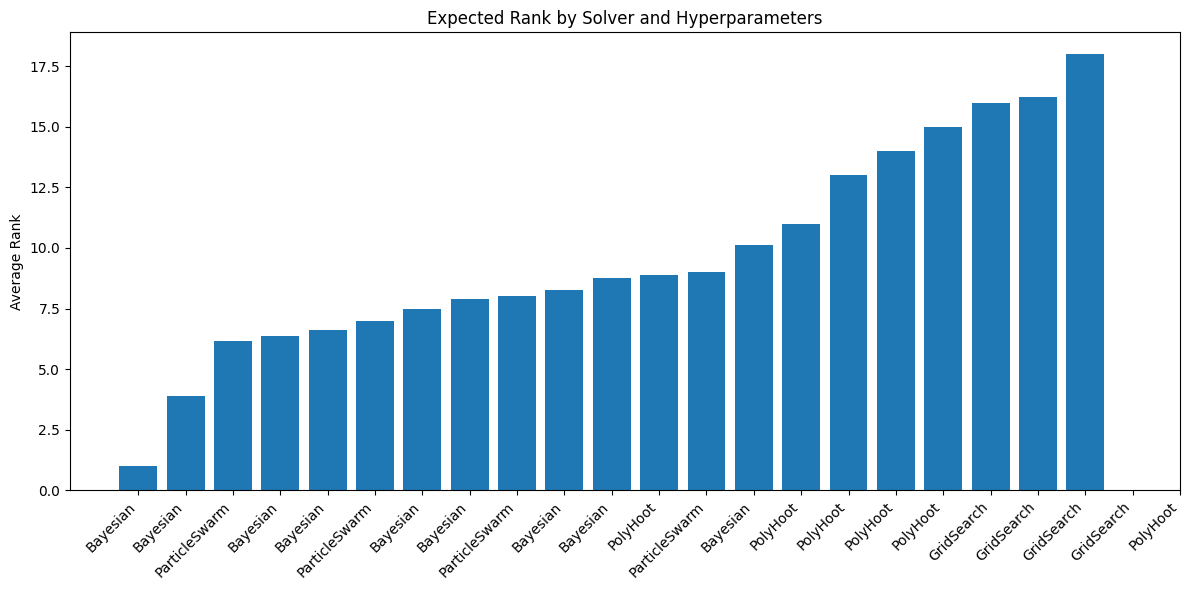

In [25]:
def collapse_experiments_by_solver_hyperparams(experiments: list[Mapping[str, Any]]) -> pd.DataFrame:
    """
    Collapse experiments to calculate expected rank when controlling only for solver and
    core hyperparameters (excluding max_iterations, objective, nested, weights).
    
    Args:
        experiments: List of experiment mappings
        
    Returns:
        DataFrame with collapsed results sorted by average rank
    """
    # Dictionary to store groups of experiments
    collapsed: dict[str, list[Mapping[str, Any]]] = {}
    
    # Group experiments by solver and filtered hyperparams
    for experiment in experiments:
        config = experiment["config"]
        result = experiment["result"]
        
        # Extract key components
        solver = config["solverName"]
        hyperp = {k: v for k, v in config["optimizer"].items() 
                 if k not in ["max_iterations", "objective", "nested", "weights"]}
        
        # Create a key for grouping
        key = json.dumps({"solver": solver, "hyperparams": hyperp}, sort_keys=True)
        
        if key not in collapsed:
            collapsed[key] = []
        
        collapsed[key].append(experiment)
    
    # Calculate statistics for each group
    results = []
    for key, group in collapsed.items():
        key_data = json.loads(key)
        
        # Calculate average metrics
        avg_rank = sum(exp["result"].get("rank", float('inf')) for exp in group) / len(group)
        avg_score = sum(exp["result"].get("score", float('inf')) for exp in group) / len(group)
        count = len(group)
        
        # Extract algorithms present in this group
        algorithms = set(exp["config"]["reconstruction_algo"] for exp in group)
        
        results.append({
            "solver": key_data["solver"],
            "hyperparams": key_data["hyperparams"],
            "avg_rank": avg_rank,
            "avg_score": avg_score,
            "count": count,
            "algorithms": list(algorithms)
        })
    
    # Convert to DataFrame for better display
    df = pd.DataFrame(results)
    # Sort by average rank
    return df.sort_values("avg_rank")

# Use the function and display results
collapsed_df = collapse_experiments_by_solver_hyperparams(all_experiments)
print(collapsed_df)

# You can also visualize the results
plt.figure(figsize=(12, 6))
plt.bar(range(len(collapsed_df)), collapsed_df["avg_rank"])
plt.xticks(range(len(collapsed_df)), 
           [f"{row['solver']}" for _, row in collapsed_df.iterrows()], 
           rotation=45, ha="right")
plt.ylabel("Average Rank")
plt.title("Expected Rank by Solver and Hyperparameters")
plt.tight_layout()
plt.show()

In [26]:
collapse_experiments_by_solver_hyperparams(all_experiments)

,solver,hyperparams,avg_rank,avg_score,count,algorithms
0,Bayesian,"{'learning_rate': 0.001, 'target_score': 0.01}",1.000000,-374818.853684,8,"[TF, ST]"
3,Bayesian,"{'learning_rate': 0.01, 'target_score': 0.01}",3.875000,-366830.684268,8,"[TF, ST]"
11,ParticleSwarm,"{'cognitive': 1.5, 'inertia': 0.5, 'social': 1...",6.142857,2067.928351,7,"[TF, ST]"
1,Bayesian,"{'learning_rate': 0.001, 'target_score': 0.1}",6.375000,-368836.829303,8,"[TF, ST]"
4,Bayesian,"{'learning_rate': 0.01, 'target_score': 0.1}",6.625000,-370752.355555,8,"[TF, ST]"
12,ParticleSwarm,"{'cognitive': 1.5, 'inertia': 0.5, 'social': 1...",7.000000,14028.130746,4,[ST]
5,Bayesian,"{'learning_rate': 0.01, 'target_score': 0.3}",7.500000,-370605.334679,8,"[TF, ST]"
6,Bayesian,"{'learning_rate': 0.1, 'target_score': 0.01}",7.875000,-375910.952241,8,"[TF, ST]"
13,ParticleSwarm,"{'cognitive': 1.5, 'inertia': 0.5, 'social': 1...",8.000000,1343.436771,4,[ST]
2,Bayesian,"{'learning_rate': 0.001, 'target_score': 0.3}",8.250000,-377576.941512,8,"[TF, ST]"


           solver                                        hyperparams  \
15       PolyHoot                                                 {}   
12  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
17       PolyHoot         {'alfa': 5.0, 'epsilon': 20.0, 'eta': 0.5}   
20       PolyHoot         {'alfa': 10, 'epsilon': 18.0, 'eta': 0.45}   
19       PolyHoot              {'alfa': 2, 'epsilon': 10, 'eta': 15}   
18       PolyHoot        {'alfa': 5.5, 'epsilon': 22.0, 'eta': 0.55}   
16       PolyHoot        {'alfa': 4.5, 'epsilon': 18.0, 'eta': 0.45}   
13  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
11  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
14  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
3        Bayesian      {'learning_rate': 0.01, 'target_score': 0.01}   
4        Bayesian       {'learning_rate': 0.01, 'target_score': 0.1}   
5        Bayesian       {'learning_rate': 0.01, 'target_score': 

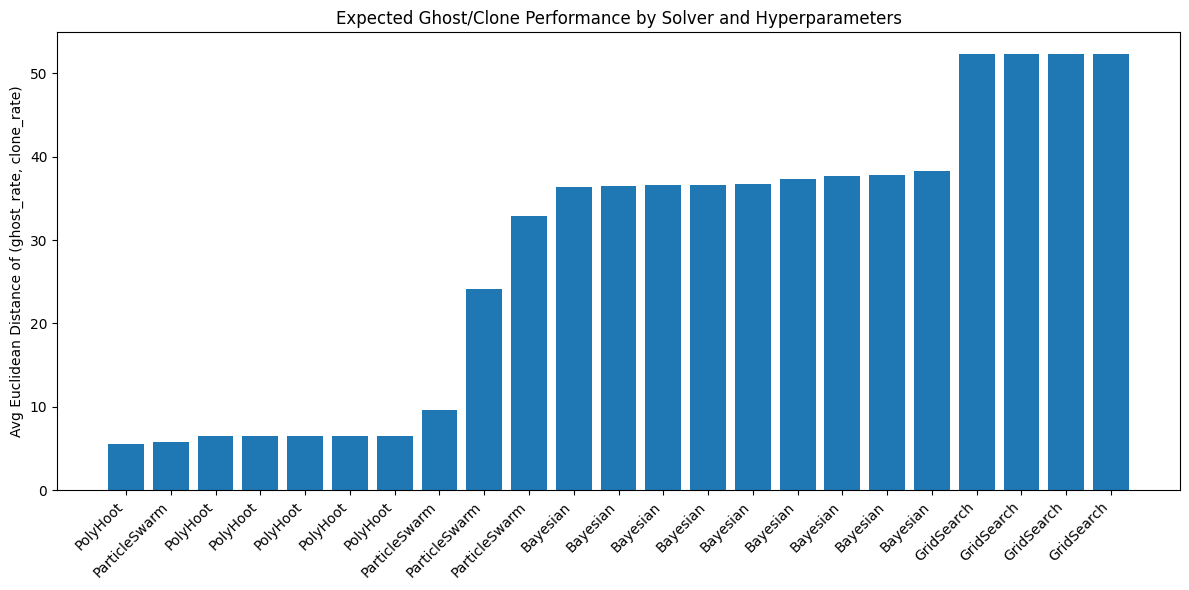

In [27]:
def rank_by_euclidean_ghost_clone(experiments: list[Mapping[str, Any]]) -> pd.DataFrame:
    """
    Rank experiments by the expected Euclidean distance of (ghost rate, clone rate)
    with respect to the origin (0,0), while controlling only for solver and hyperparameters
    (excluding max_iterations, objective, nested, weights).
    
    Args:
        experiments: List of experiment mappings
        
    Returns:
        DataFrame with collapsed results sorted by average Euclidean distance
    """
    # Dictionary to store groups of experiments
    collapsed: dict[str, list[Mapping[str, Any]]] = {}
    
    # Group experiments by solver and filtered hyperparams
    for experiment in experiments:
        config = experiment["config"]
        
        # Extract key components
        solver = config["solverName"]
        hyperp = {k: v for k, v in config["optimizer"].items() 
                if k not in ["max_iterations", "objective", "nested", "weights"]}
        
        # Create a key for grouping
        key = json.dumps({"solver": solver, "hyperparams": hyperp}, sort_keys=True)
        
        if key not in collapsed:
            collapsed[key] = []
        
        collapsed[key].append(experiment)
    
    # Calculate statistics for each group
    results = []
    for key, group in collapsed.items():
        key_data = json.loads(key)
        
        # Calculate euclidean distances for each experiment in group
        distances = []
        for exp in group:
            result = exp["result"]
            ghost_rate = result.get("event_avg_ghost_rate", 0)
            clone_rate = result.get("clone_percentage", 0)
            
            # Calculate Euclidean distance from origin (0,0)
            distance = (ghost_rate**2 + clone_rate**2)**0.5
            distances.append(distance)
        
        # Calculate average distance
        avg_distance = sum(distances) / len(distances) if distances else float('inf')
        
        # Extract algorithms present in this group
        algorithms = set(exp["config"]["reconstruction_algo"] for exp in group)
        
        # Calculate average score for reference
        avg_score = sum(exp["result"].get("score", float('inf')) for exp in group) / len(group)
        
        results.append({
            "solver": key_data["solver"],
            "hyperparams": key_data["hyperparams"],
            "avg_euclidean_distance": avg_distance,
            "avg_score": avg_score,
            "count": len(group),
            "algorithms": list(algorithms)
        })
    
    # Convert to DataFrame for better display
    df = pd.DataFrame(results)
    # Sort by average Euclidean distance (ascending - lower is better)
    return df.sort_values("avg_euclidean_distance")

# Use the function and display results
euclidean_df = rank_by_euclidean_ghost_clone(all_experiments)
print(euclidean_df[["solver", "hyperparams", "avg_euclidean_distance", "count", "algorithms"]])

# Visualize the results
plt.figure(figsize=(12, 6))
plt.bar(range(len(euclidean_df)), euclidean_df["avg_euclidean_distance"])
plt.xticks(range(len(euclidean_df)), 
          [f"{row['solver']}" for _, row in euclidean_df.iterrows()], 
          rotation=45, ha="right")
plt.ylabel("Avg Euclidean Distance of (ghost_rate, clone_rate)")
plt.title("Expected Ghost/Clone Performance by Solver and Hyperparameters")
plt.tight_layout()
plt.show()

           solver                                        hyperparams  \
15       PolyHoot                                                 {}   
12  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
17       PolyHoot         {'alfa': 5.0, 'epsilon': 20.0, 'eta': 0.5}   
20       PolyHoot         {'alfa': 10, 'epsilon': 18.0, 'eta': 0.45}   
19       PolyHoot              {'alfa': 2, 'epsilon': 10, 'eta': 15}   
18       PolyHoot        {'alfa': 5.5, 'epsilon': 22.0, 'eta': 0.55}   
16       PolyHoot        {'alfa': 4.5, 'epsilon': 18.0, 'eta': 0.45}   
13  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
11  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
14  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
3        Bayesian      {'learning_rate': 0.01, 'target_score': 0.01}   
4        Bayesian       {'learning_rate': 0.01, 'target_score': 0.1}   
1        Bayesian      {'learning_rate': 0.001, 'target_score': 

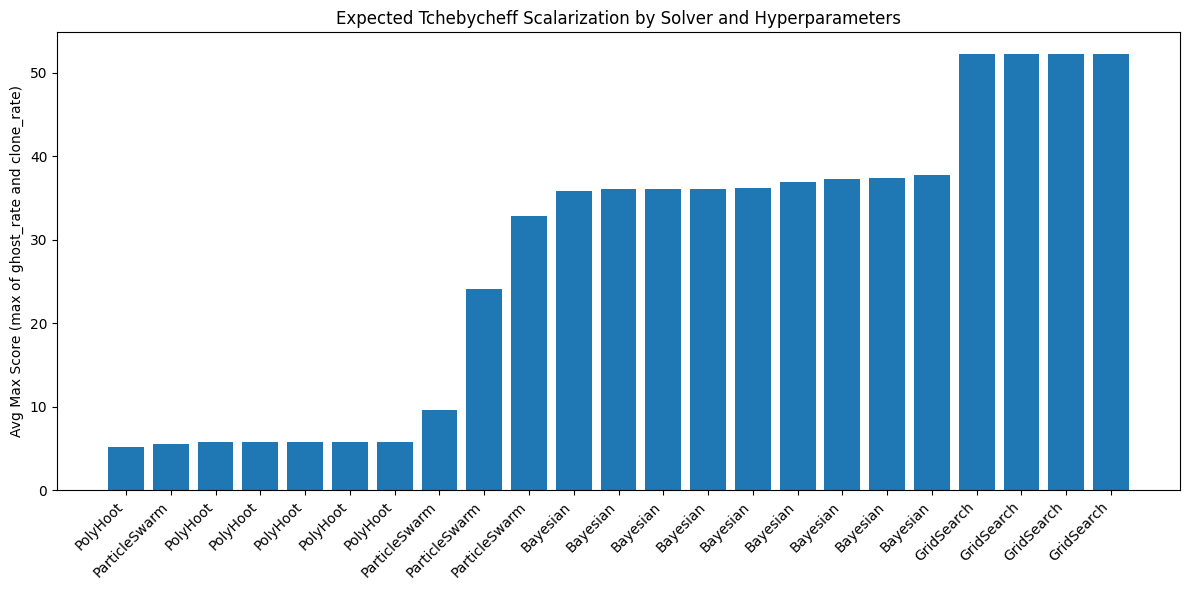

In [28]:
def rank_by_max_ghost_clone(experiments: list[Mapping[str, Any]]) -> pd.DataFrame:
    """
    Rank experiments using max(wx·|X-X*|, wy·|Y-Y*|) formula where:
    - X is ghost_rate, Y is clone_rate
    - X* and Y* are 0 (ideal values)
    - wx and wy are both 1.0
    
    This controls only for solver and hyperparameters
    (excluding max_iterations, objective, nested, weights).
    
    Args:
        experiments: List of experiment mappings
        
    Returns:
        DataFrame with collapsed results sorted by average max score
    """
    # Dictionary to store groups of experiments
    collapsed: dict[str, list[Mapping[str, Any]]] = {}
    
    # Group experiments by solver and filtered hyperparams
    for experiment in experiments:
        config = experiment["config"]
        
        # Extract key components
        solver = config["solverName"]
        hyperp = {k: v for k, v in config["optimizer"].items() 
                if k not in ["max_iterations", "objective", "nested", "weights"]}
        
        # Create a key for grouping
        key = json.dumps({"solver": solver, "hyperparams": hyperp}, sort_keys=True)
        
        if key not in collapsed:
            collapsed[key] = []
        
        collapsed[key].append(experiment)
    
    # Calculate statistics for each group
    results = []
    for key, group in collapsed.items():
        key_data = json.loads(key)
        
        # Calculate max scores for each experiment in group
        max_scores = []
        for exp in group:
            result = exp["result"]
            ghost_rate = result.get("event_avg_ghost_rate", 0)
            clone_rate = result.get("clone_percentage", 0)
            
            # Calculate using max(wx·|X-X*|, wy·|Y-Y*|) with wx=wy=1.0
            # Since X*=Y*=0, this simplifies to max(ghost_rate, clone_rate)
            max_score = max(ghost_rate, clone_rate)
            # max_score = min(ghost_rate, clone_rate)
            max_scores.append(max_score)
        
        # Calculate average max score
        avg_max_score = sum(max_scores) / len(max_scores) if max_scores else float('inf')
        
        # Extract algorithms present in this group
        algorithms = set(exp["config"]["reconstruction_algo"] for exp in group)
        
        # Calculate average score for reference
        avg_score = sum(exp["result"].get("score", float('inf')) for exp in group) / len(group)
        
        results.append({
            "solver": key_data["solver"],
            "hyperparams": key_data["hyperparams"],
            "avg_max_score": avg_max_score,
            "avg_score": avg_score,
            "count": len(group),
            "algorithms": list(algorithms)
        })
    
    # Convert to DataFrame for better display
    df = pd.DataFrame(results)
    # Sort by average max score (ascending - lower is better)
    return df.sort_values("avg_max_score")

# Use the function and display results
max_score_df = rank_by_max_ghost_clone(all_experiments)
print(max_score_df[["solver", "hyperparams", "avg_max_score", "count", "algorithms"]])

# Visualize the results
plt.figure(figsize=(12, 6))
plt.bar(range(len(max_score_df)), max_score_df["avg_max_score"])
plt.xticks(range(len(max_score_df)), 
          [f"{row['solver']}" for _, row in max_score_df.iterrows()], 
          rotation=45, ha="right")
plt.ylabel("Avg Max Score (max of ghost_rate and clone_rate)")
plt.title("Expected Tchebycheff Scalarization by Solver and Hyperparameters")
plt.tight_layout()
plt.show()

In [29]:
max_score_df.head()

,solver,hyperparams,avg_max_score,avg_score,count,algorithms
15,PolyHoot,{},5.147393,7169.898198,8,"[TF, ST]"
12,ParticleSwarm,"{'cognitive': 1.5, 'inertia': 0.5, 'social': 1...",5.552016,14028.130746,4,[ST]
17,PolyHoot,"{'alfa': 5.0, 'epsilon': 20.0, 'eta': 0.5}",5.749332,15901.795522,2,[ST]
20,PolyHoot,"{'alfa': 10, 'epsilon': 18.0, 'eta': 0.45}",5.749332,15901.777238,1,[ST]
19,PolyHoot,"{'alfa': 2, 'epsilon': 10, 'eta': 15}",5.749332,15901.787650,1,[ST]


In [30]:
# Define formatting parameters
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
dpi = 100

# Update global plot formatting
plt.rcParams.update({
    "text.usetex": True,
    "font.family":       "serif",
    "font.serif":        ["Times New Roman", "Palatino", "serif"],
    "axes.titlesize":    title_fontsize,
    "axes.labelsize":    label_fontsize,
    "xtick.labelsize":   tick_fontsize,
    "ytick.labelsize":   tick_fontsize,
    "figure.dpi":        dpi,
    "axes.linewidth":    1.0,
    "xtick.major.size":  5,
    "ytick.major.size":  5,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "axes.grid":         True,
    "grid.color":        "#999999",
    "grid.alpha":        0.2,
    "grid.linestyle":    "--"
})

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(max_score_df)), max_score_df["avg_max_score"], color="#4C4C4C")
plt.xticks(
    range(len(max_score_df)), 
    [f"{row['solver']} \n ({row['algorithms']})" for _, row in max_score_df.iterrows()], 
    rotation=45, ha="right"
)
plt.ylabel("Avg Max Score (max of ghost_rate and clone_rate)")
plt.title("Expected Tchebycheff Scalarization by Solver and Hyperparameters")
plt.tight_layout()
plt.show()


RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x00000276609B0310> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1200x600 with 1 Axes>

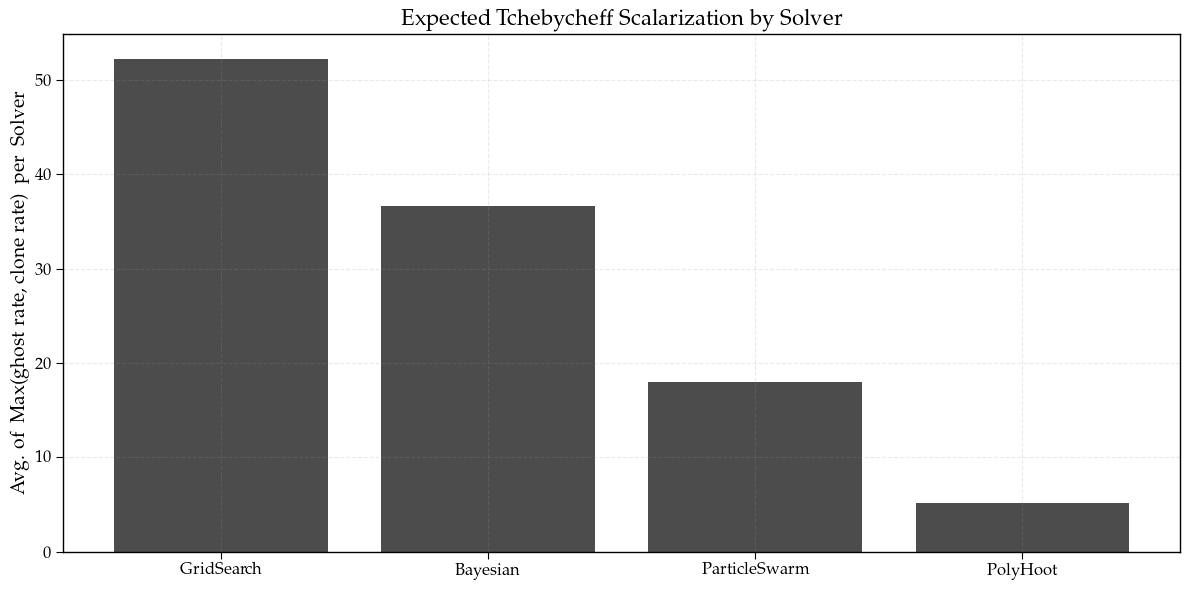

In [ ]:
# Group by solver and compute mean (or use .max() if that better fits your intent)
grouped_df = (
    max_score_df.groupby("solver")["avg_max_score"]
    .mean()
    .reset_index()
    .sort_values("avg_max_score", ascending=False)
)


# Update plot settings
plt.figure(figsize=(12, 6))
plt.bar(range(len(grouped_df)), grouped_df["avg_max_score"], color="#4C4C4C")
plt.xticks(
    range(len(grouped_df)), 
    grouped_df["solver"], 
    rotation=0, ha="center"
)
plt.ylabel(r"Avg. of \space Max(ghost rate, clone rate) \space per \space Solver")
plt.title("Expected Tchebycheff Scalarization by Solver")
plt.tight_layout()
plt.show()


## Try smth different

           solver                                        hyperparams  \
12  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
0   ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
14  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
15       PolyHoot                                                 {}   
6   ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
1      GridSearch                                  {'resolution': 7}   
7      GridSearch                                 {'resolution': 10}   
17     GridSearch                                 {'resolution': 42}   
16     GridSearch                                 {'resolution': 50}   
13       Bayesian     {'learning_rate': 0.001, 'target_score': 0.01}   
4        Bayesian        {'learning_rate': 0.1, 'target_score': 0.1}   
2        Bayesian       {'learning_rate': 0.01, 'target_score': 0.3}   
9        Bayesian       {'learning_rate': 0.01, 'target_score': 

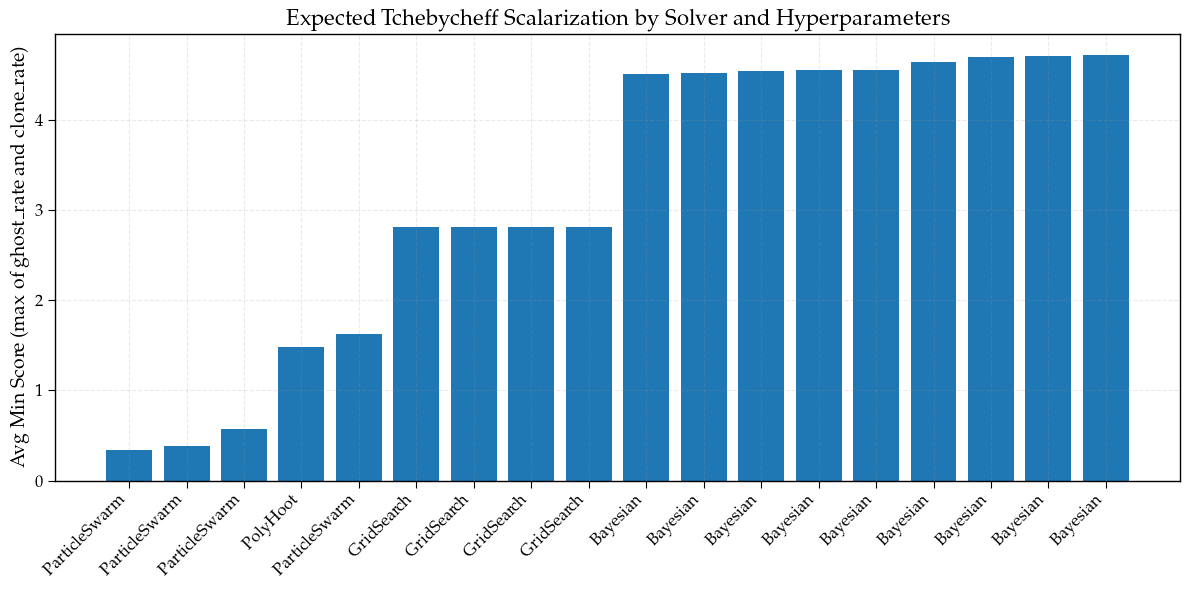

In [ ]:
def rank_by_min_ghost_clone(experiments: list[Mapping[str, Any]]) -> pd.DataFrame:
    """
    Rank experiments using max(wx·|X-X*|, wy·|Y-Y*|) formula where:
    - X is ghost_rate, Y is clone_rate
    - X* and Y* are 0 (ideal values)
    - wx and wy are both 1.0
    
    This controls only for solver and hyperparameters
    (excluding max_iterations, objective, nested, weights).
    
    Args:
        experiments: List of experiment mappings
        
    Returns:
        DataFrame with collapsed results sorted by average max score
    """
    # Dictionary to store groups of experiments
    collapsed: dict[str, list[Mapping[str, Any]]] = {}
    
    # Group experiments by solver and filtered hyperparams
    for experiment in experiments:
        config = experiment["config"]
        
        # Extract key components
        solver = config["solverName"]
        hyperp = {k: v for k, v in config["optimizer"].items() 
                if k not in ["max_iterations", "objective", "nested", "weights"]}
        
        # Create a key for grouping
        key = json.dumps({"solver": solver, "hyperparams": hyperp}, sort_keys=True)
        
        if key not in collapsed:
            collapsed[key] = []
        
        collapsed[key].append(experiment)
    
    # Calculate statistics for each group
    results = []
    for key, group in collapsed.items():
        key_data = json.loads(key)
        
        # Calculate max scores for each experiment in group
        max_scores = []
        for exp in group:
            result = exp["result"]
            ghost_rate = result.get("event_avg_ghost_rate", 0)
            clone_rate = result.get("clone_percentage", 0)
            
            # Calculate using max(wx·|X-X*|, wy·|Y-Y*|) with wx=wy=1.0
            # Since X*=Y*=0, this simplifies to max(ghost_rate, clone_rate)
            # max_score = max(ghost_rate, clone_rate)
            max_score = min(ghost_rate, clone_rate)
            max_scores.append(max_score)
        
        # Calculate average max score
        avg_max_score = sum(max_scores) / len(max_scores) if max_scores else float('inf')
        
        # Extract algorithms present in this group
        algorithms = set(exp["config"]["reconstruction_algo"] for exp in group)
        
        # Calculate average score for reference
        avg_score = sum(exp["result"].get("score", float('inf')) for exp in group) / len(group)
        
        results.append({
            "solver": key_data["solver"],
            "hyperparams": key_data["hyperparams"],
            "avg_max_score": avg_max_score,
            "avg_score": avg_score,
            "count": len(group),
            "algorithms": list(algorithms)
        })
    
    # Convert to DataFrame for better display
    df = pd.DataFrame(results)
    # Sort by average max score (ascending - lower is better)
    return df.sort_values("avg_max_score")

# Use the function and display results
max_score_df = rank_by_min_ghost_clone(all_experiments)
print(max_score_df[["solver", "hyperparams", "avg_max_score", "count", "algorithms"]])

# Visualize the results
plt.figure(figsize=(12, 6))
plt.bar(range(len(max_score_df)), max_score_df["avg_max_score"])
plt.xticks(range(len(max_score_df)), 
          [f"{row['solver']}" for _, row in max_score_df.iterrows()], 
          rotation=45, ha="right")
plt.ylabel("Avg Min Score (max of ghost_rate and clone_rate)")
plt.title("Expected Tchebycheff Scalarization by Solver and Hyperparameters")
plt.tight_layout()
plt.show()

## Ecliduan distances

           solver                                        hyperparams  \
15       PolyHoot                                                 {}   
6   ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
12  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
0   ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
14  ParticleSwarm  {'cognitive': 1.5, 'inertia': 0.5, 'social': 1...   
11       Bayesian      {'learning_rate': 0.01, 'target_score': 0.01}   
9        Bayesian       {'learning_rate': 0.01, 'target_score': 0.1}   
2        Bayesian       {'learning_rate': 0.01, 'target_score': 0.3}   
5        Bayesian      {'learning_rate': 0.001, 'target_score': 0.1}   
4        Bayesian        {'learning_rate': 0.1, 'target_score': 0.1}   
13       Bayesian     {'learning_rate': 0.001, 'target_score': 0.01}   
10       Bayesian      {'learning_rate': 0.001, 'target_score': 0.3}   
3        Bayesian       {'learning_rate': 0.1, 'target_score': 0

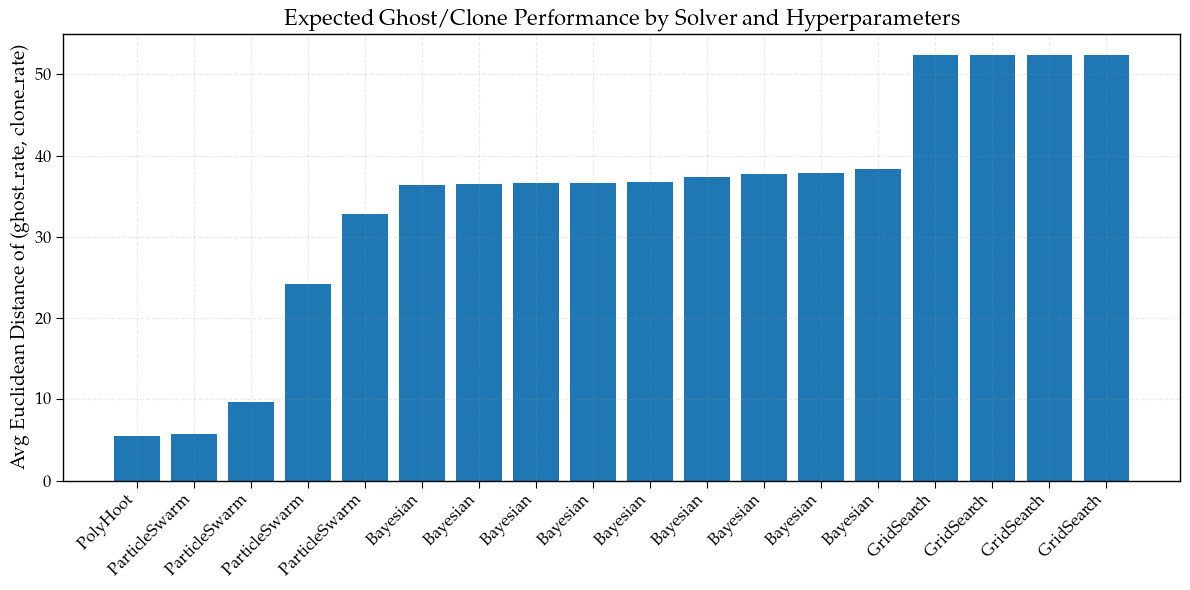

In [ ]:
# Use the function and display results
euclidean_df = rank_by_euclidean_ghost_clone(all_experiments)
print(euclidean_df[["solver", "hyperparams", "avg_euclidean_distance", "count", "algorithms"]])

plt.rcParams.update({
    # "text.usetex": True,
    "font.family":       "serif",
    "font.serif":        ["Times New Roman", "Palatino", "serif"],
    "axes.titlesize":    title_fontsize,
    "axes.labelsize":    label_fontsize,
    "xtick.labelsize":   tick_fontsize,
    "ytick.labelsize":   tick_fontsize,
    "figure.dpi":        dpi,
    "axes.linewidth":    1.0,
    "xtick.major.size":  5,
    "ytick.major.size":  5,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "axes.grid":         True,
    "grid.color":        "#999999",
    "grid.alpha":        0.2,
    "grid.linestyle":    "--"
})
# Visualize the results
plt.figure(figsize=(12, 6))
plt.bar(range(len(euclidean_df)), euclidean_df["avg_euclidean_distance"])
plt.xticks(range(len(euclidean_df)), 
          [f"{row['solver']}" for _, row in euclidean_df.iterrows()], 
          rotation=45, ha="right")
plt.ylabel("Avg Euclidean Distance of (ghost_rate, clone_rate)")
plt.title("Expected Ghost/Clone Performance by Solver and Hyperparameters")
plt.tight_layout()
plt.show()

## Euclidean Distances

In [ ]:
def rank_by_euclidean_ghost_clone_CG(experiments: list[Mapping[str, Any]]) -> pd.DataFrame:
    """
    Rank experiments by the expected Euclidean distance of (ghost rate, clone rate)
    with respect to the origin (0,0), while controlling only for solver and hyperparameters
    (excluding max_iterations, objective, nested, weights).
    
    Args:
        experiments: List of experiment mappings
        
    Returns:
        DataFrame with collapsed results sorted by average Euclidean distance
    """
    # Dictionary to store groups of experiments
    collapsed: dict[str, list[Mapping[str, Any]]] = {}
    
    # Group experiments by solver and filtered hyperparams
    for experiment in experiments:
        config = experiment["config"]
        
        # Extract key components
        solver = config["solverName"]
        hyperp = {k: v for k, v in config["optimizer"].items() 
                if k not in ["max_iterations", "objective", "nested", "weights"]}
        
        # Create a key for grouping
        key = json.dumps({"solver": solver, "hyperparams": hyperp}, sort_keys=True)
        
        if key not in collapsed:
            collapsed[key] = []
        
        collapsed[key].append(experiment)
    
    # Calculate statistics for each group
    results = []
    for key, group in collapsed.items():
        key_data = json.loads(key)
        
        # Calculate euclidean distances for each experiment in group
        distances = []
        for exp in group:
            result = exp["result"]
            ghost_rate = result.get("event_avg_ghost_rate", 0)
            clone_rate = result.get("clone_percentage", 0)
            
            # Calculate Euclidean distance from origin (0,0)
            distance = (ghost_rate**2 + clone_rate**2)**0.5
            distances.append(distance)
        
        # Calculate average distance
        avg_distance = sum(distances) / len(distances) if distances else float('inf')
        
        # Extract algorithms present in this group
        algorithms = set(exp["config"]["reconstruction_algo"] for exp in group)
        
        # Calculate average score for reference
        avg_score = sum(exp["result"].get("score", float('inf')) for exp in group) / len(group)
        
        results.append({
            "solver": key_data["solver"],
            "hyperparams": key_data["hyperparams"],
            "avg_euclidean_distance": avg_distance,
            "avg_score": avg_score,
            "count": len(group),
            "algorithms": list(algorithms)
        })
    
    # Convert to DataFrame for better display
    df = pd.DataFrame(results)
    # Sort by average Euclidean distance (ascending - lower is better)
    return df.sort_values("avg_euclidean_distance")

In [ ]:
def rank_by_euclidean_ghost_clone_min(experiments: list[Mapping[str, Any]]) -> pd.DataFrame:
    """
    Rank experiments by the expected Euclidean distance of (ghost rate, clone rate)
    with respect to the origin (0,0), while controlling only for solver and hyperparameters
    (excluding max_iterations, objective, nested, weights).
    
    Args:
        experiments: List of experiment mappings
        
    Returns:
        DataFrame with collapsed results sorted by average Euclidean distance
    """
    # Dictionary to store groups of experiments
    collapsed: dict[str, list[Mapping[str, Any]]] = {}
    
    # Group experiments by solver and filtered hyperparams
    for experiment in experiments:
        config = experiment["config"]
        
        # Extract key components
        solver = config["solverName"]
        hyperp = {k: v for k, v in config["optimizer"].items() 
                if k not in ["max_iterations", "objective", "nested", "weights"]}
        
        # Create a key for grouping
        key = json.dumps({"solver": solver, "hyperparams": hyperp}, sort_keys=True)
        
        if key not in collapsed:
            collapsed[key] = []
        
        collapsed[key].append(experiment)
    
    # Calculate statistics for each group
    results = []
    for key, group in collapsed.items():
        key_data = json.loads(key)
        
        # Calculate euclidean distances for each experiment in group
        distances = []
        scores = []
        for exp in group:
            result = exp["result"]
            ghost_rate = result.get("event_avg_ghost_rate", 0)
            clone_rate = result.get("clone_percentage", 0)
            
            # Calculate Euclidean distance from origin (0,0)
            distance = (ghost_rate**2 + clone_rate**2)**0.5
            distances.append(distance)
            scores.append(result.get("score", float('inf')))
        
        # Calculate average distance
        avg_distance = sum(distances) / len(distances) if distances else float('inf')
        
        # Extract algorithms present in this group
        algorithms = set(exp["config"]["reconstruction_algo"] for exp in group)
        
        # Calculate average score for reference
        avg_score = sum(exp["result"].get("score", float('inf')) for exp in group) / len(group)
        
        results.append({
            "solver": key_data["solver"],
            "hyperparams": key_data["hyperparams"],
            "avg_euclidean_distance": min(distances),
            "avg_score": min(scores),
            "count": len(group),
            "algorithms": list(algorithms)
        })
    
    # Convert to DataFrame for better display
    df = pd.DataFrame(results)
    # Sort by average Euclidean distance (ascending - lower is better)
    return df.sort_values("avg_euclidean_distance")

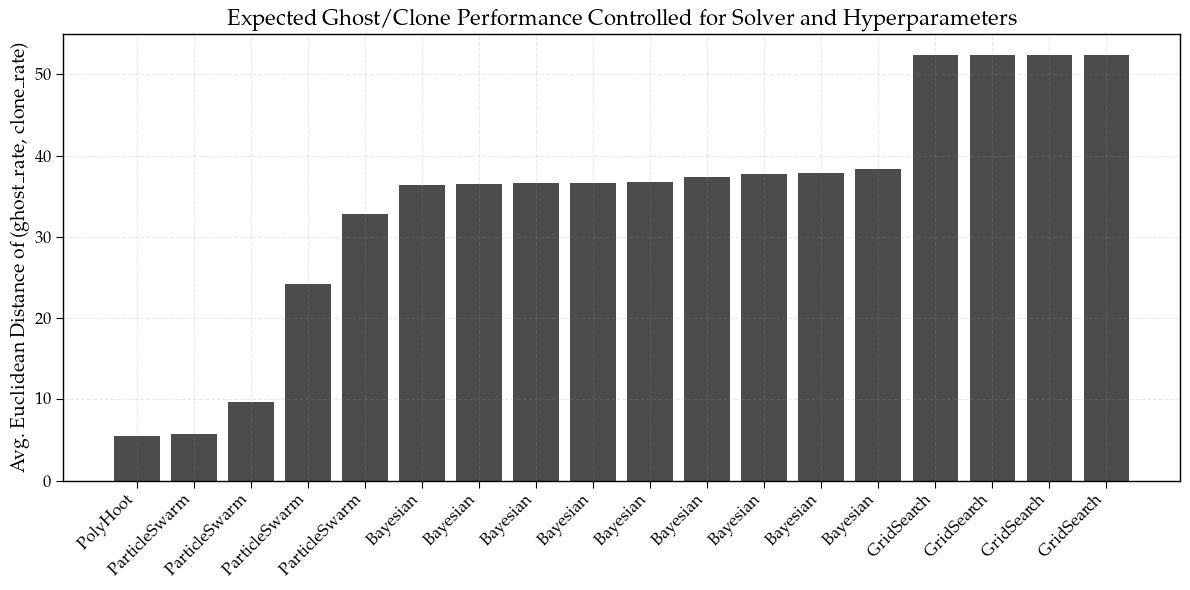

In [ ]:
import matplotlib.pyplot as plt

# Assuming CG_euclidean and euclidean_df are already computed
euclidean_df = rank_by_euclidean_ghost_clone_CG(all_experiments)

# Define formatting parameters
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
dpi = 100

# Safely update global plot formatting
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Palatino", "serif"],
    "axes.titlesize": title_fontsize,
    "axes.labelsize": label_fontsize,
    "xtick.labelsize": tick_fontsize,
    "ytick.labelsize": tick_fontsize,
    "figure.dpi": dpi,
    "axes.linewidth": 1.0,
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "axes.grid": True,
    "grid.color": "#999999",
    "grid.alpha": 0.2,
    "grid.linestyle": "--"
})

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
bars = ax.bar(range(len(euclidean_df)), euclidean_df["avg_euclidean_distance"], color="#4C4C4C")

# Set x-tick labels
ax.set_xticks(range(len(euclidean_df)))
ax.set_xticklabels(
    [f"{row['solver']}" for _, row in euclidean_df.iterrows()],
    rotation=45, ha="right"
)

# Set labels and title (these will respect rcParams if no fontsize/family passed directly)
ax.set_ylabel(r"Avg.\ Euclidean\ Distance\ of\ (ghost\_rate,\ clone\_rate)")
ax.set_title(r"Avg.\ Ghost/Clone\ Performance\ Controlled\ for\ Solver\ and\ Hyperparameters")

# Apply layout and show
fig.tight_layout()
plt.show()


**Generate Grouping such its a more simplified plot**

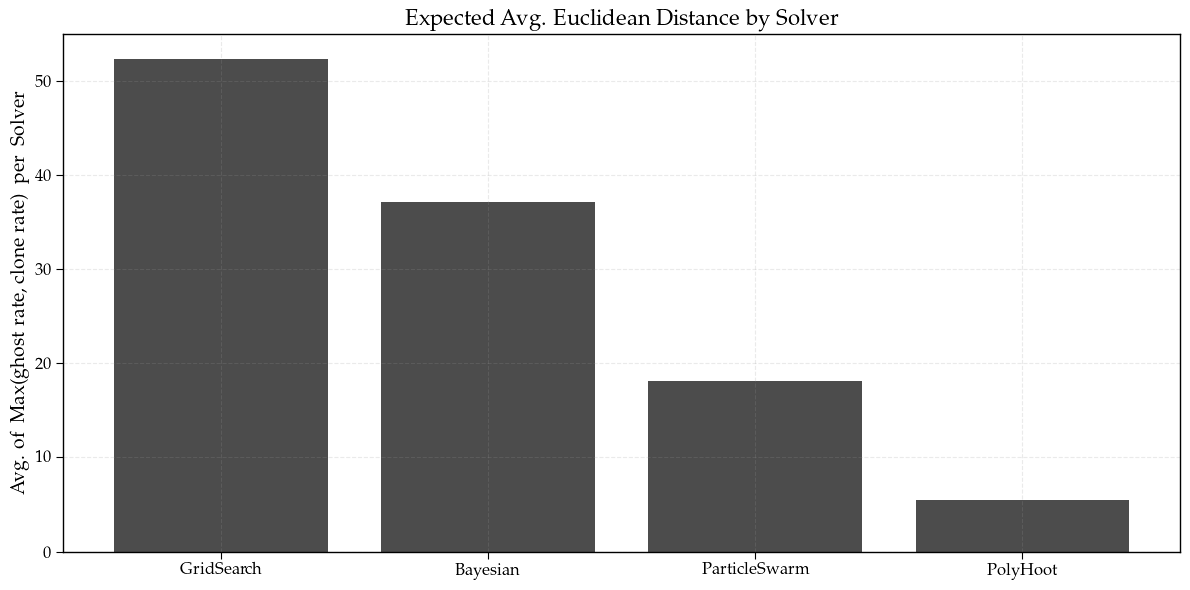

In [ ]:
# Group by solver and compute mean (or use .max() if that better fits your intent)
grouped_df = (
    euclidean_df.groupby("solver")["avg_euclidean_distance"]
    .mean()
    .reset_index()
    .sort_values("avg_euclidean_distance", ascending=False)
)


# Update plot settings
plt.figure(figsize=(12, 6))
plt.bar(range(len(grouped_df)), grouped_df["avg_euclidean_distance"], color="#4C4C4C")
plt.xticks(
    range(len(grouped_df)), 
    grouped_df["solver"], 
    rotation=0, ha="center"
)
plt.ylabel(r"Avg. of \space Max(ghost rate, clone rate) \space per \space Solver")
plt.title("Expected Avg. Euclidean Distance by Solver")
plt.tight_layout()
plt.show()


#### Now lets do the same for minimal (optimal) Distance

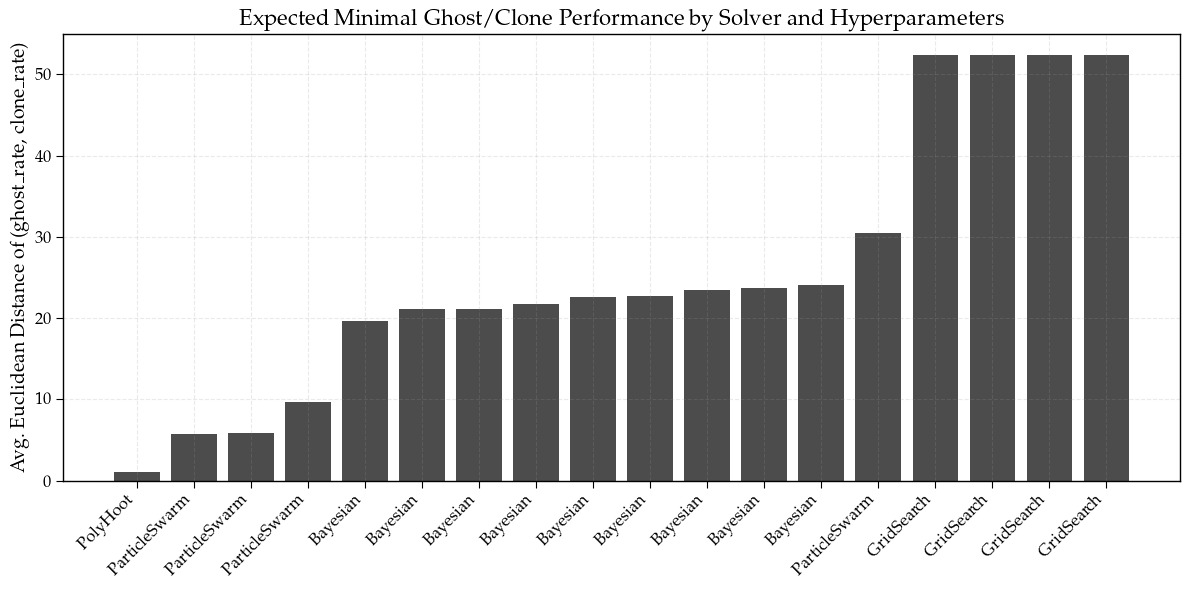

In [ ]:
euclidean_df_min = rank_by_euclidean_ghost_clone_min(all_experiments)
# Define formatting parameters
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
dpi = 100
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
bars = ax.bar(range(len(euclidean_df_min)), euclidean_df_min["avg_euclidean_distance"], color="#4C4C4C")

# Set x-tick labels
ax.set_xticks(range(len(euclidean_df_min)))
ax.set_xticklabels(
    [f"{row['solver']}" for _, row in euclidean_df_min.iterrows()],
    rotation=45, ha="right"
)

# Set labels and title (these will respect rcParams if no fontsize/family passed directly)
ax.set_ylabel(r"Avg.\ Euclidean\ Distance\ of\ (ghost\_rate,\ clone\_rate)")
ax.set_title(r"Expected\ Minimal\ Ghost/Clone\ Performance\ by\ Solver\ and\ Hyperparameters")

# Apply layout and show
fig.tight_layout()
plt.show()


**Also Simplify**


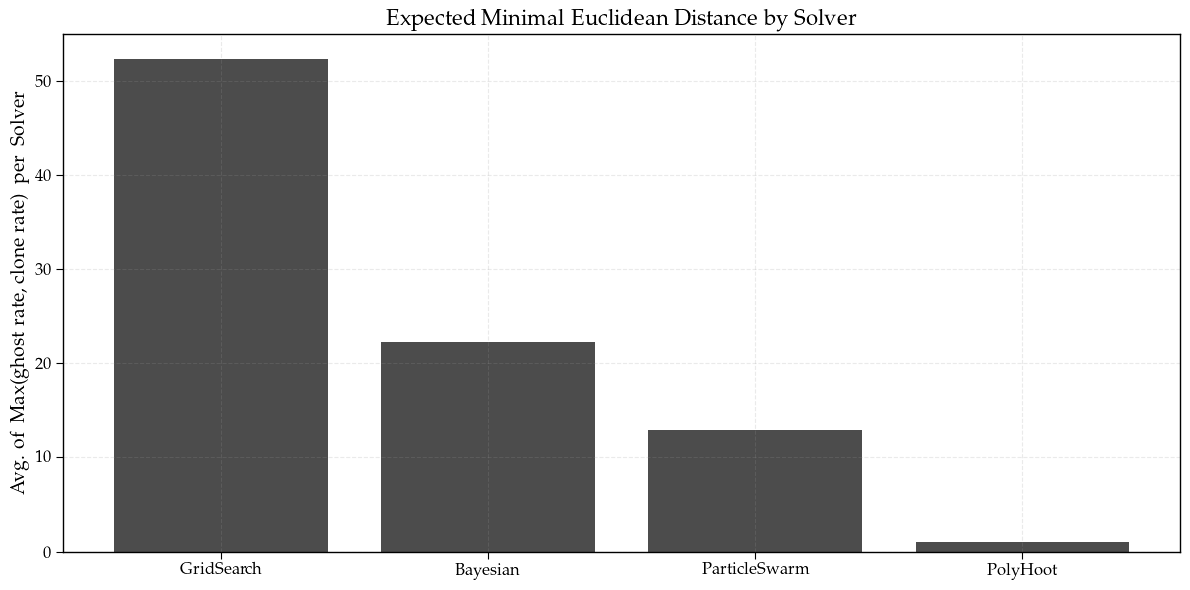

In [ ]:
# Group by solver and compute mean (or use .max() if that better fits your intent)
grouped_df = (
    euclidean_df_min.groupby("solver")["avg_euclidean_distance"]
    .mean()
    .reset_index()
    .sort_values("avg_euclidean_distance", ascending=False)
)


# Update plot settings
plt.figure(figsize=(12, 6))
plt.bar(range(len(grouped_df)), grouped_df["avg_euclidean_distance"], color="#4C4C4C")
plt.xticks(
    range(len(grouped_df)), 
    grouped_df["solver"], 
    rotation=0, ha="center"
)
plt.ylabel(r"Avg. of \space Max(ghost rate, clone rate) \space per \space Solver")
plt.title("Expected Minimal Euclidean Distance by Solver")
plt.tight_layout()
plt.show()


## PLOT SCORES


In [ ]:
# filter the results for one weight: (0.1, 0.3, 0.5, -10.0) 
# so iterate through the results of the experiments that used this weight, take the best score for each of the algorithms and plot them side by side


Algorithm: ST, Weights: (0.1, 0.3, 0.5, -10.0)
Rank  Dominates  Dominated by Ratio    Configuration                                
------------------------------------------------------------------------------------------
1     9          6            0.60     Bayesian on ST with learning_rate=0.001, target_score=0.01, weights=[0.1, 0.3, 0.5, -10.0]
2     8          7            0.53     Bayesian on ST with learning_rate=0.001, target_score=0.3, weights=[0.1, 0.3, 0.5, -10.0]
3     7          8            0.47     Bayesian on ST with learning_rate=0.01, target_score=0.01, weights=[0.1, 0.3, 0.5, -10.0]
4     6          9            0.40     Bayesian on ST with learning_rate=0.01, target_score=0.1, weights=[0.1, 0.3, 0.5, -10.0]
5     5          10           0.33     Bayesian on ST with learning_rate=0.1, target_score=0.1, weights=[0.1, 0.3, 0.5, -10.0]
6     4          11           0.27     ParticleSwarm on ST with cognitive=1.5, inertia=0.5, social=1.5, swarm_size=3, weights=[0.1, 0.